<a href="https://colab.research.google.com/github/marinabar/hugging_face/blob/main/imgclassification_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Install necessary librairies



In [1]:
!pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 31.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 74.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.2 MB/s eta 0:00:00


In [2]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.6 MB/s eta 0:00:00


In [3]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 1.8 MB/s eta 0:00:00


In [4]:
from huggingface_hub import notebook_login
notebook_login()

## Set up GPU

In [5]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

In [6]:
print(device)

cuda


### Load dataset and defined training data

In [9]:
from datasets import load_dataset

In [10]:
dataset = load_dataset("m1b/vkscoredata", split="train")
#create test split
dataset = dataset.train_test_split(test_size=0.2)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating test split:   0%|          | 0/19982 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/79928 [00:00<?, ? examples/s]

In [11]:
dataset["train"][19]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=540x358>,
 'SCORE': 6}

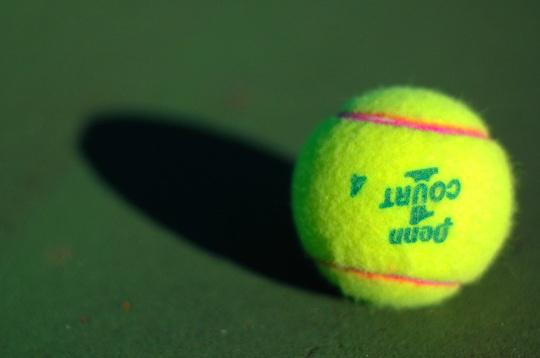

In [12]:
dataset["train"][19]["image"]

In [13]:
labels=["0","1","2","3","4","5","6","7","8","9", "10"]

In [14]:
dataset['train'].features

{'image': Image(decode=True, id=None), 'SCORE': Value(dtype='int64', id=None)}

In [15]:
dataset = dataset.rename_column("SCORE", "labels")

Create dicts mapping id to label name

In [16]:
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

In [17]:
batch_size = 2
model_config='google/vit-base-patch16-224-in21k'

In [18]:
print(id2label)

{0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: '10'}


In [19]:
labels = torch.tensor(labels)

ValueError: ignored

### Augment data

In [20]:
from transformers import set_seed

set_seed(42)

In [21]:
from transformers import ViTFeatureExtractor

image_processor  = ViTFeatureExtractor.from_pretrained(model_config)
image_processor

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


ViTFeatureExtractor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTFeatureExtractor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

In [22]:
from torchvision.transforms import CenterCrop, Compose, Normalize, RandomAdjustSharpness, RandomHorizontalFlip, RandomResizedCrop, Resize, ToTensor

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            Resize(size),
            RandomHorizontalFlip(),
            RandomAdjustSharpness(sharpness_factor=5, p=0.5),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(examples):
    """Apply train_transforms across a batch."""
    examples["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in examples["image"]
    ]
    return examples

def preprocess_val(examples):
    """Apply val_transforms across a batch."""
    examples["pixel_values"] = [val_transforms(image.convert("RGB")) for image in examples["image"]]
    return examples

Huggingface function to automatically map augmentation function and convert image to tensors

In [23]:
train_ds = dataset['train']
val_ds = dataset['test']

In [24]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [37]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["labels"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [39]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_ds, collate_fn=collate_fn, batch_size=batch_size )
eval_dataloader = DataLoader(val_ds, collate_fn=collate_fn, batch_size=batch_size )

### Define metrics and analyzing function

In [27]:
num_epochs=5

In [28]:
import evaluate

accuracy = evaluate.load("accuracy")

### Define model

In [29]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained(
    model_config,
    num_labels=len(labels),
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this to fine-tune an already fine-tuned checkpoint
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
for name, param in model.named_parameters():
    if 'classifier' not in name:
      param.requires_grad=False

In [ ]:
for name, param in model.named_parameters():
    print(name,param.requires_grad)

In [34]:
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                )

In [35]:
from transformers import get_linear_schedule_with_warmup

total_steps = len(train_dataloader) * num_epochs

lr_scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 2000, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
#model.classifier = nn.Sequential(nn.Dropout(0.2),nn.Linear(1280, len(labels)))

## Train model

In [40]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(total_steps))

model.to(device)

for epoch in range(num_epochs):
    model.train()
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    for batch in eval_dataloader:
      batch = {k: v.to(device) for k, v in batch.items()}
      with torch.no_grad():
        outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        accuracy.add_batch(predictions=predictions, references=batch["labels"])

accuracy.compute()

  0%|          | 0/159855 [00:00<?, ?it/s]

{'accuracy': 0.42023020142624795}

In [41]:
torch.save(model.state_dict(), './vkimg')

In [43]:
model.push_to_hub("vkpytorch")

pytorch_model.bin:   0%|          | 0.00/343M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/m1b/vkpytorch/commit/ed9bb7c201b10263fc495cc429be690612cd11e4', commit_message='Upload ViTForImageClassification', commit_description='', oid='ed9bb7c201b10263fc495cc429be690612cd11e4', pr_url=None, pr_revision=None, pr_num=None)

## Use:

In [50]:
from PIL import Image
import requests

url = 'test1.jpg'
image = Image.open(url)

To execute only if model isn't loaded locally

In [ ]:
from transformers import AutoModelForImageClassification, AutoImageProcessor

repo_name = "m1b/vkpytorch"

image_processor = AutoImageProcessor.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(repo_name)

In [51]:
encoding = image_processor(image.convert("RGB"), return_tensors="pt")

The following is to use only in the case of model weights being already on the gpu

In [52]:
encoding = encoding.to("cuda")

In [53]:
import torch
# forward pass
with torch.no_grad():
    outputs = model(**encoding)
    logits = outputs.logits

#get probabilities
prob=torch.nn.functional.softmax(logits, dim=1) #convert logits to prob
topprob=prob.sort(descending=True)[0][0][:5].tolist() # get top 5 prob
# get top five categories
top5=logits.argsort(descending=True)[0][:5].tolist()

print(*[f"Predicted {i+1} class: {model.config.id2label[(top5[i])]} - probability : {round(topprob[i], 4)} \n" for i in range(5)])

Predicted 1 class: 5 - probability : 0.3394 
 Predicted 2 class: 4 - probability : 0.2754 
 Predicted 3 class: 6 - probability : 0.1849 
 Predicted 4 class: 3 - probability : 0.0913 
 Predicted 5 class: 7 - probability : 0.0613 



Evaluate

In [ ]:
dataset = load_dataset('food101', split='validation[:10%]')

In [ ]:
from evaluate import evaluator
task_evaluator = evaluator("image-classification")

eval_results = task_evaluator.compute(
    model_or_pipeline=model,
    data=dataset,
    label_mapping=model.config.label2id,
    feature_extractor=image_processor
)

In [ ]:
print(eval_results)

{'accuracy': 0.7275247524752475, 'total_time_in_seconds': 65.98596456500036, 'samples_per_second': 38.26571327168696, 'latency_in_seconds': 0.02613305527326747}
